In [1]:
!nvidia-smi

Thu Mar 14 19:01:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:27:00.0 Off |                    0 |
| N/A   32C    P0             63W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
import argparse

class Args(argparse.Namespace):
    image_size=256
    centered=True
    num_channels_dae=64
    n_mlp=3
    ch_mult=[1,1,2,2,4,4]
    num_res_blocks=2
    attn_resolutions=(16,)
    dropout=0.
    resamp_with_conv=True
    conditional=True
    fir=True
    fir_kernel=[1, 3, 3, 1]
    skip_rescale=True
    resblock_type='biggan'
    progressive='none'
    progressive_input='residual'
    progressive_combine='sum'
    embedding_type='positional'
    fourier_scale=16.
    not_use_tanh=False
    z_emb_dim=256
    nz=100
    ngf=64
    num_channels=3
    batch_size=32
    
    
args=Args()

In [3]:
import os, sys
# sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

import numpy as np
import torch
import torch.nn as nn
import torchvision
import gc

# from src import distributions
import torch.nn.functional as F

from src.models.resnet import ResNet_D
from src.models.unet import UNet
from src.models.u2net import U2NET, U2NETP, EMA

from src.dataset.dataset import unfreeze, freeze, weights_init_D, load_dataset, load_celeba
from src.metrics.fid_score import calculate_frechet_distance
from src.metrics.inception import InceptionV3
# from src.plotters import plot_random_images, plot_images

from copy import deepcopy
import json

from tqdm import tqdm_notebook as tqdm
from IPython.display import clear_output

import wandb # <--- online logging of the results
from src.dataset.dataset import fig2data, fig2img # for wandb

# This needed to use dataloaders for some datasets
from PIL import PngImagePlugin
LARGE_ENOUGH_NUMBER = 100
PngImagePlugin.MAX_TEXT_CHUNK = LARGE_ENOUGH_NUMBER * (1024**2)

In [4]:
torch.__version__

'2.1.0+cu121'

In [16]:
def get_pushed_loader_stats_old(T, loader, batch_size=8, verbose=False, device='cuda',
                            use_downloaded_weights=False):
    dims = 2048
    block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
    model = InceptionV3([block_idx]).to(device)
    freeze(model); freeze(T)
    
    size = len(loader.dataset)
    pred_arr = []
    
    with torch.no_grad():
        for step, (X, _) in enumerate(loader) if not verbose else tqdm(enumerate(loader)):
            for i in range(0, len(X), batch_size):
                start, end = i, min(i + batch_size, len(X))
                z = torch.randn(end-start, 100, device=device)
                batch = T(X[start:end].type(torch.FloatTensor).to(device)).add(1).mul(.5)
                pred_arr.append(model(batch)[0].cpu().data.numpy().reshape(end-start, -1))

    pred_arr = np.vstack(pred_arr)
    mu, sigma = np.mean(pred_arr, axis=0), np.cov(pred_arr, rowvar=False)
    gc.collect(); torch.cuda.empty_cache()
    return mu, sigma

def plot_images(X, Y, T):
    freeze(T);
    z = torch.randn(X.size(0), 100).cuda()
    with torch.no_grad():
        T_X = T(X, z)
        imgs = torch.cat([X, T_X, Y]).to('cpu').permute(0,2,3,1).mul(0.5).add(0.5).numpy().clip(0,1)

    fig, axes = plt.subplots(3, 10, figsize=(15, 4.5), dpi=150)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(imgs[i])
        ax.get_xaxis().set_visible(False)
        ax.set_yticks([])
        
    axes[0, 0].set_ylabel('X', fontsize=24)
    axes[1, 0].set_ylabel('T(X)', fontsize=24)
    axes[2, 0].set_ylabel('Y', fontsize=24)
    
    fig.tight_layout(pad=0.001)
    torch.cuda.empty_cache(); gc.collect()
    return fig, axes

def plot_random_images(X_sampler, Y_sampler, T):
    X = X_sampler.sample(10)
    Y = Y_sampler.sample(10)
    return plot_images(X, Y, T)

## Main Config

In [6]:
DEVICE_IDS = [0]

# DATASET1, DATASET1_PATH = 'outdoor', '../pSp/datasets/outdoor_128.hdf5'
# DATASET2, DATASET2_PATH = 'church', './datasets/church_128.hdf5'

DATASET1, DATASET1_PATH = 'celeba_male', 'datasets/CelebA_HQ'
DATASET2, DATASET2_PATH = 'celeba_female', 'datasets/CelebA_HQ'

# DATASET1, DATASET1_PATH = 'celeba_female', '../../data/img_align_celeba'
# DATASET2, DATASET2_PATH = 'aligned_anime_faces', '../../data/aligned_anime_faces'

T_ITERS = 10
f_LR, T_LR = 1e-4, 2e-4
IMG_SIZE = 256

BATCH_SIZE = 32

PLOT_INTERVAL = 200
COST = 'mse' # Mean Squared Error
CPKT_INTERVAL = 1000
MAX_STEPS = 100001
SEED = 0x000000

EXP_NAME = f'{DATASET1}_{DATASET2}_T{T_ITERS}_{COST}_{IMG_SIZE}_uot_kl_batch64'
OUTPUT_PATH = '../checkpoints/{}/{}_{}_{}/'.format(COST, DATASET1, DATASET2, IMG_SIZE)

## Preparation

In [7]:
config = dict(
    DATASET1=DATASET1,
    DATASET2=DATASET2, 
    T_ITERS=T_ITERS,
    f_LR=f_LR, T_LR=T_LR,
    BATCH_SIZE=BATCH_SIZE
)
    
assert torch.cuda.is_available()
torch.cuda.set_device(f'cuda:{DEVICE_IDS[0]}')
torch.manual_seed(SEED); np.random.seed(SEED)

# if not os.path.exists(OUTPUT_PATH):
#     os.makedirs(OUTPUT_PATH)

## Prepare Samplers (X, Y)

In [8]:
# X_sampler, X_test_sampler = load_dataset(DATASET1, DATASET1_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE)
# Y_sampler, Y_test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE, batch_size=BATCH_SIZE)

X_sampler = load_celeba('datasets/CelebA_HQ', "male", True, batch_size=BATCH_SIZE)
X_test_sampler = load_celeba('datasets/CelebA_HQ', "male", False, batch_size=BATCH_SIZE)

Y_sampler = load_celeba('datasets/CelebA_HQ', "female", True, batch_size=BATCH_SIZE)
Y_test_sampler = load_celeba('datasets/CelebA_HQ', "female", False, batch_size=BATCH_SIZE)
    
torch.cuda.empty_cache(); gc.collect()
# clear_output()

/trinity/home/nikita.andreev/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


6

## Loading data stats for testing

In [10]:
# from src.dataset.dataset import get_loader_stats

# _, test_sampler = load_dataset(DATASET2, DATASET2_PATH, img_size=IMG_SIZE)
# mu, sigma = get_loader_stats(test_sampler.loader, device='cuda', use_downloaded_weights=False)
# stats = {'mu' : mu.tolist(), 'sigma' : sigma.tolist()}
# print('Stats computed')

# filename = '{}_{}_test.json'.format(DATASET2, IMG_SIZE)
# with open(filename, 'w') as fp:
#     json.dump(stats, fp)
# print('Stats saved to {}'.format(filename))

Keys: <KeysViewHDF5 ['imgs']>


/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Stats computed
Stats saved to church_128_test.json


In [9]:
filename = './{}_{}_test.json'.format(DATASET2, IMG_SIZE)
with open(filename, 'r') as fp:
    data_stats = json.load(fp)
    mu_data, sigma_data = data_stats['mu'], data_stats['sigma']
del data_stats

In [9]:
len(Y_sampler.loader)
474 277

474

# Initializing Networks

In [ ]:
# from src.models.ncsn.models.ncsnpp_generator_adagn import NCSNpp
# T = NCSNpp(args).cuda()

# from src.models.ncsn.models.discriminator import Discriminator_large, Discriminator_small
# f = Discriminator_large(nc=args.num_channels, ngf=args.ngf, act=nn.LeakyReLU(0.2)).cuda()

# print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
# print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

ImportError: /trinity/shared/opt/anaconda3/lib/python3.8/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /beegfs/home/nikita.andreev/.cache/torch_extensions/py38_cu121/fused/fused.so)

In [8]:
# !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html --upgrade --force-reinstall

Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 1156.8 MB 87 kB/s /s eta 0:00:01 |▏                               | 7.4 MB 80.2 MB/s eta 0:00:15     |▊                               | 26.7 MB 80.2 MB/s eta 0:00:15     |██                              | 76.2 MB 35.5 MB/s eta 0:00:31     |██▏                             | 78.9 MB 35.5 MB/s eta 0:00:31     |█████                           | 183.5 MB 102.5 MB/s eta 0:00:10     |█████▎                          | 192.2 MB 102.5 MB/s eta 0:00:10     |█████▌                          | 200.4 MB 102.5 MB/s eta 0:00:10     |█████▉                          | 209.1 MB 102.5 MB/s eta 0:00:10     |██████                          | 213.3 MB 102.5 MB/s eta 0:00:10     |██████                          | 217.5 MB 102.5 MB/s eta 0:00:10     |████████▎                       | 297.3 MB 68.6 MB/s eta 0:00:13     |████████

In [14]:
f = ResNet_D(IMG_SIZE, nc=3).cuda()
f.apply(weights_init_D)

T = UNet(3, 3, base_factor=64).cuda()
# T = U2NET(in_ch=3, out_ch=3).cuda()

# if len(DEVICE_IDS) > 1:
#     T = nn.DataParallel(T, device_ids=DEVICE_IDS)
#     f = nn.DataParallel(f, device_ids=DEVICE_IDS)
    
print('T params:', np.sum([np.prod(p.shape) for p in T.parameters()]))
print('f params:', np.sum([np.prod(p.shape) for p in f.parameters()]))

T params: 17258691
f params: 41811905


In [17]:
mu, sigma = get_pushed_loader_stats_old(T, X_test_sampler.loader)

In [11]:
import copy

ema = EMA(0.999)
ema_model = copy.deepcopy(T).cuda()

start_ema = 30000

In [12]:
torch.manual_seed(0xBADBEEF); np.random.seed(0xBADBEEF)
X_fixed = X_sampler.sample(10)
Y_fixed = Y_sampler.sample(10)
X_test_fixed = X_test_sampler.sample(10)
Y_test_fixed = Y_test_sampler.sample(10)

### Plots Test

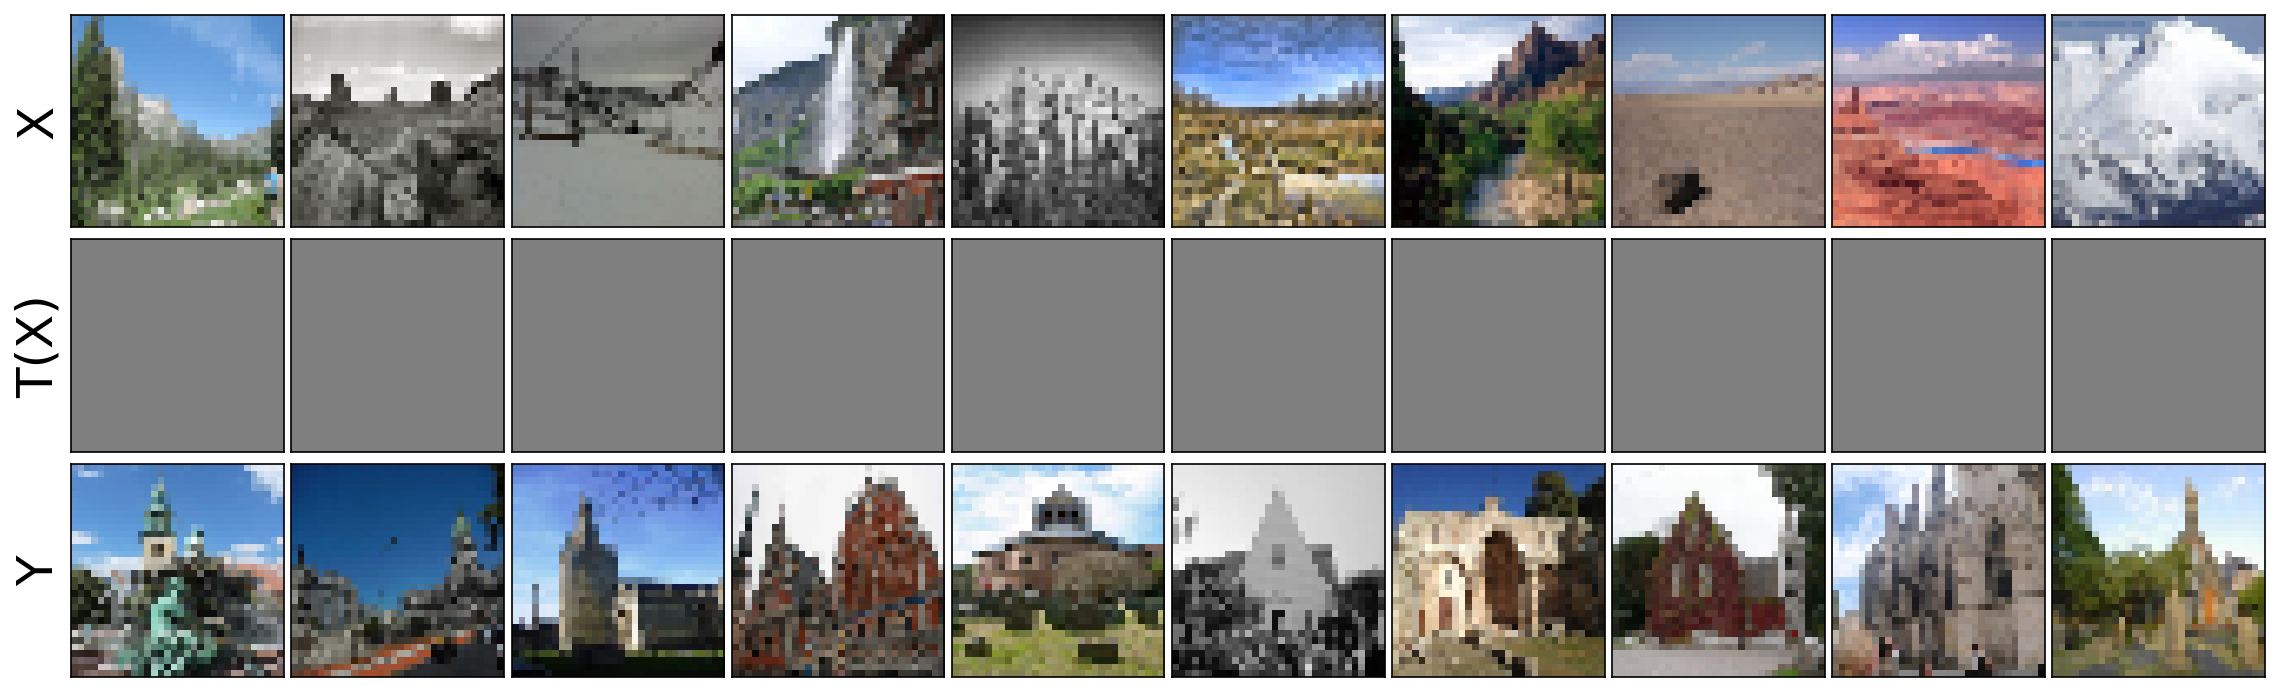

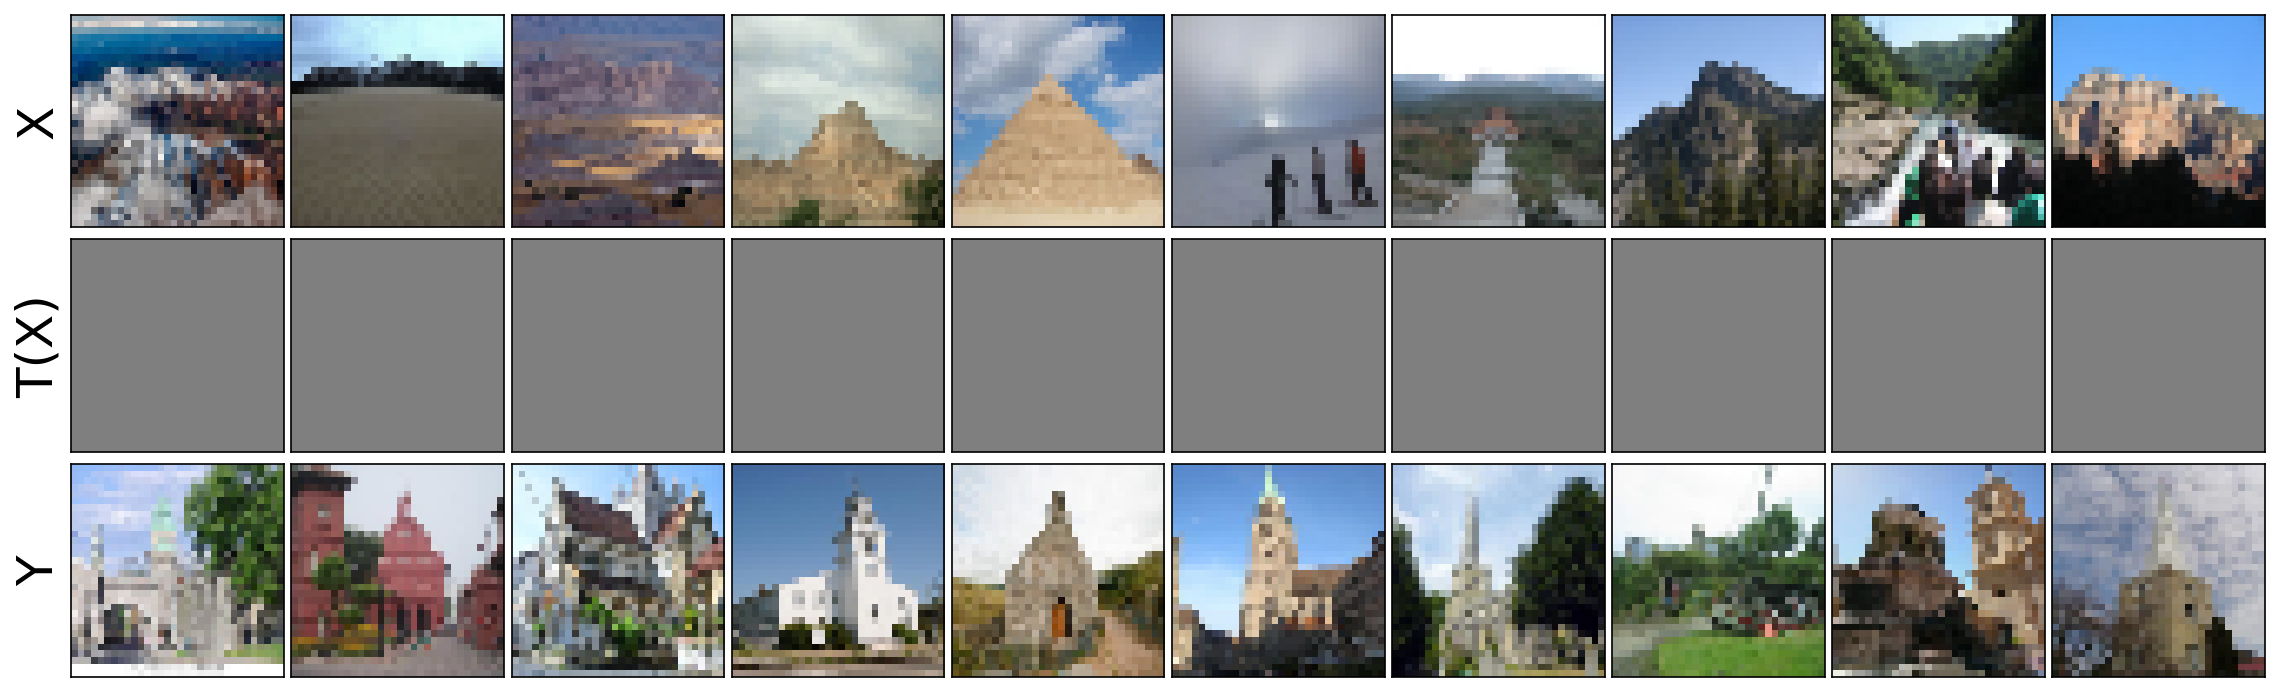

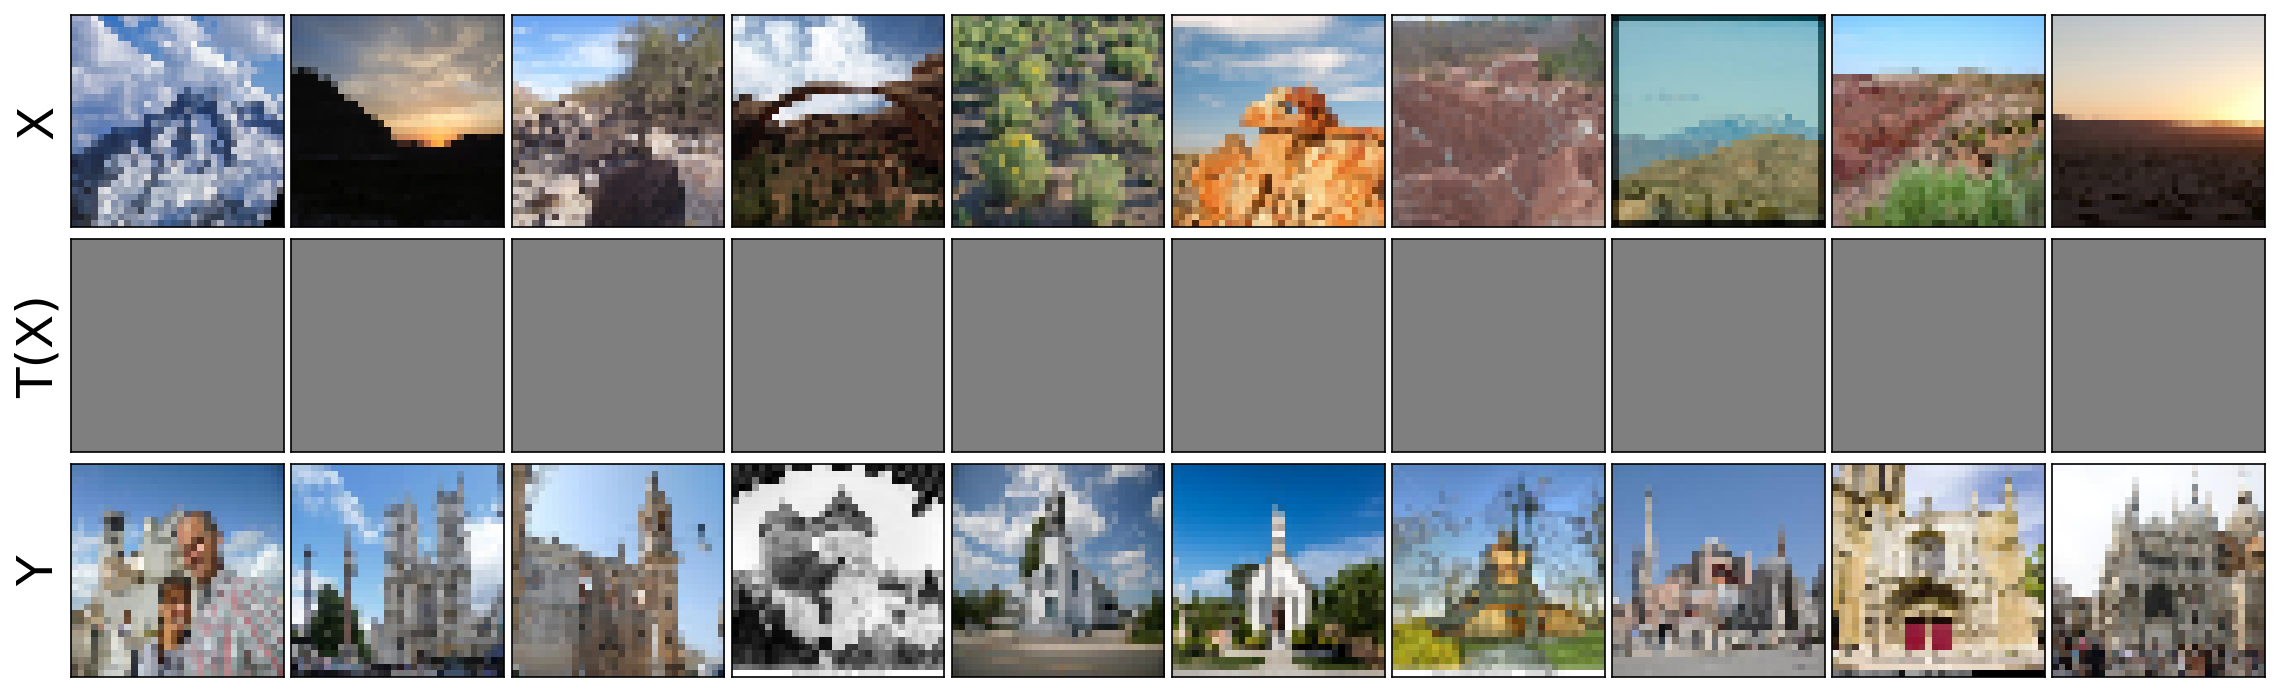

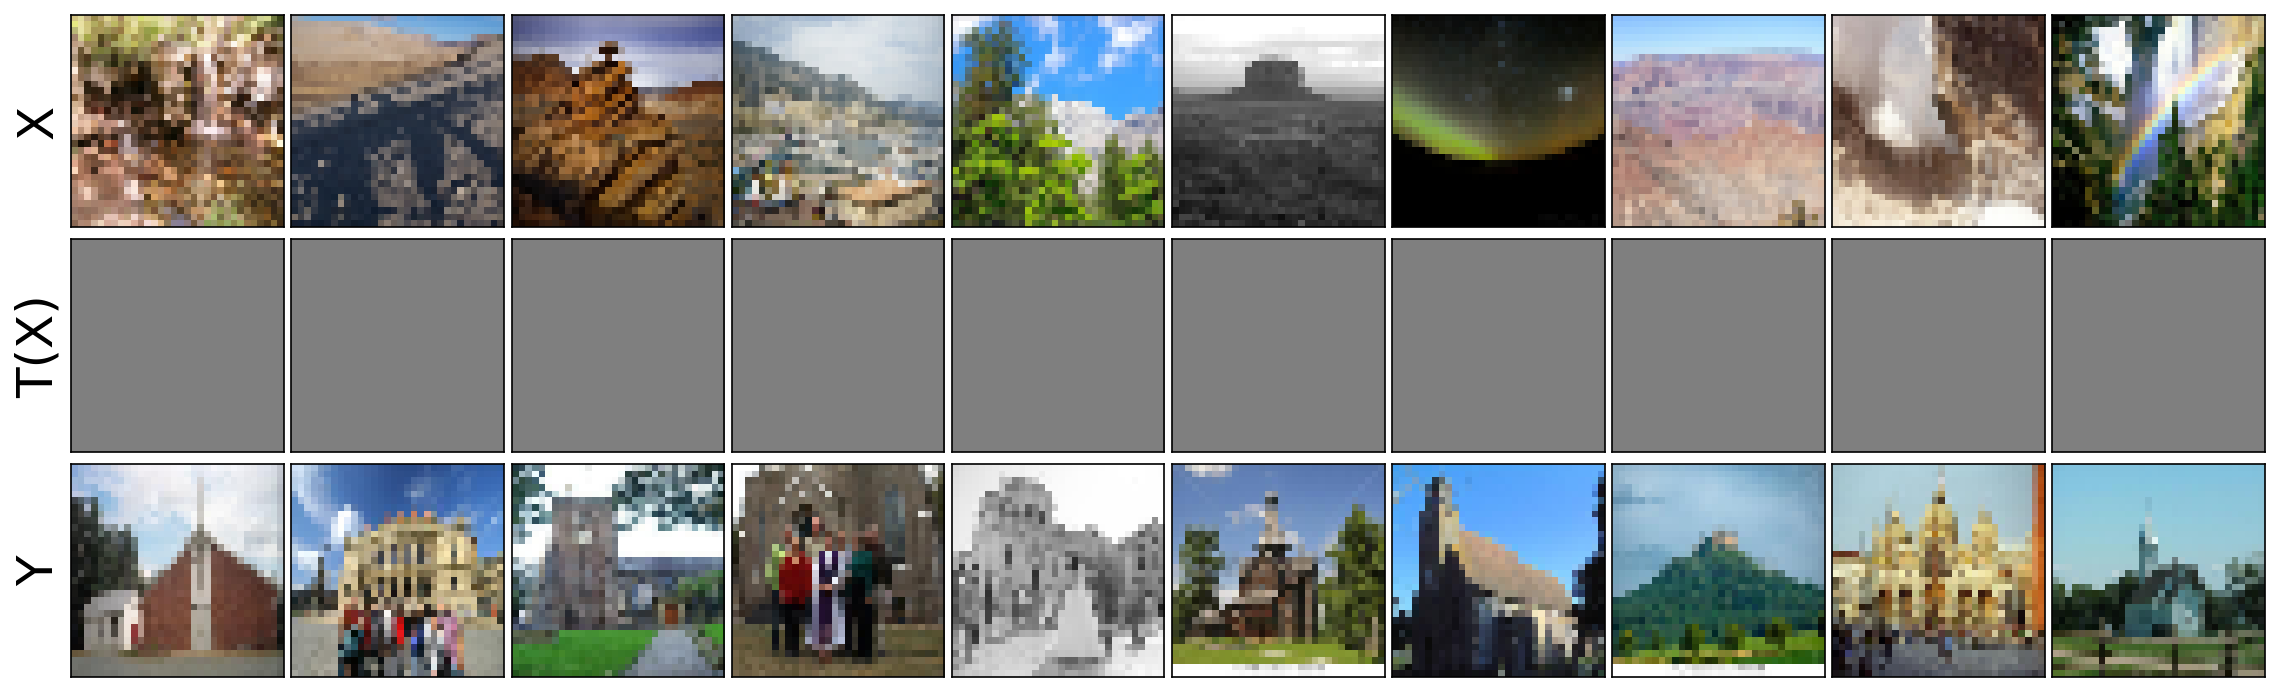

In [14]:
fig, axes = plot_images(X_fixed, Y_fixed, T)
fig, axes = plot_random_images(X_sampler, Y_sampler, T)
fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)

# Run Training

In [ ]:
!wandb login <your_token>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [14]:
wandb.init(name=EXP_NAME, project='progressive_growing_OT_first_gpu', config=config)
pass

wandb: Currently logged in as: nikich28 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [15]:
T_opt = torch.optim.Adam(T.parameters(), lr=T_LR, betas=(0.5, 0.9))
f_opt = torch.optim.Adam(f.parameters(), lr=f_LR, betas=(0.5, 0.9))

sch_f = torch.optim.lr_scheduler.CosineAnnealingLR(f_opt, 700, eta_min=1e-5)
sch_T = torch.optim.lr_scheduler.CosineAnnealingLR(T_opt, 700, eta_min=1e-5)

In [ ]:
phi1 = lambda x: torch.exp(x)
phi2 = lambda x: torch.exp(x)

tau = 0.00001
r1_gamma = 5

In [ ]:
for step in tqdm(range(MAX_STEPS)):
    # T optimization
    unfreeze(T); freeze(f)
    for t_iter in range(T_ITERS):
        T_opt.zero_grad()
        X = X_sampler.sample(BATCH_SIZE)
        z = torch.randn(BATCH_SIZE, args.nz).cuda()
        T_X = T(X, z)
        if COST == 'mse':
#             T_loss = F.mse_loss(X, T_X).mean() - f(T_X).mean()
            T_loss = (tau * torch.sum(((T_X - X).view(X.size(0), -1))**2, dim=1) - f(T_X)).mean()
        else:
            raise Exception('Unknown COST')
        T_loss.backward(); T_opt.step()
    wandb.log({f'T_loss' : T_loss.item()}, step=step)
    del T_loss, T_X, X, z; gc.collect(); torch.cuda.empty_cache()

    # f optimization
    freeze(T); unfreeze(f)
    X = X_sampler.sample(BATCH_SIZE)
#     Y = Y_sampler.sample(BATCH_SIZE)
    z = torch.randn(BATCH_SIZE, args.nz).cuda()
    with torch.no_grad():
        T_X = T(X, z)
    Y = Y_sampler.sample(BATCH_SIZE)
    Y.requires_grad = True
    f_opt.zero_grad()
    
    f_real = f(Y)
    f_loss_real = phi2(-f_real).mean()
    f_loss_real.backward(retain_graph=True)
    
#     y_push = f(Y)
    grad_ = torch.autograd.grad(outputs=f_real.sum(), inputs=Y, create_graph=True)[0]
    grad_penalty = (grad_.view(grad_.size(0), -1).norm(2, dim=1) ** 2).mean()
    grad_penalty = r1_gamma / 2 * grad_penalty
    grad_penalty.backward()
    
    
    f_loss_fake = phi1(f(T_X) - tau * torch.sum(((T_X - X).view(X.size(0), -1))**2, dim=1)).mean()
    f_loss_fake.backward()
    
    f_loss = f_loss_real + f_loss_fake
    
#     f_loss = f(T_X).mean() - f(Y).mean()
#     f_loss.backward(); f_opt.step();
    f_opt.step()
    wandb.log({f'f_loss' : f_loss.item()}, step=step) 
    del f_loss, Y, X, T_X, z; gc.collect(); torch.cuda.empty_cache()
    
    if (step + 1) % 500 == 0:
        sch_f.step()
        sch_T.step()
    
    if (step + 1) == start_ema:
        ema_model = copy.deepcopy(T).cuda()
        freeze(ema_model)
    if (step + 1) > start_ema:
        ema.update_model_average(ema_model, T)
        
    if (step + 1) % PLOT_INTERVAL == 0:
        print('Plotting')
        clear_output(wait=True)
        
        fig, axes = plot_images(X_fixed, Y_fixed, T)
        wandb.log({'Fixed Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_sampler,  Y_sampler, T)
        wandb.log({'Random Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_images(X_test_fixed, Y_test_fixed, T)
        wandb.log({'Fixed Test Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
        plt.show(fig); plt.close(fig) 
        
        fig, axes = plot_random_images(X_test_sampler, Y_test_sampler, T)
        wandb.log({'Random Test Images' : [wandb.Image(fig2img(fig))]}, step=step+1) 
        plt.show(fig); plt.close(fig)
        
        if (step + 1) >= start_ema:
        
            fig, axes = plot_images(X_fixed, Y_fixed, ema_model)
            wandb.log({'Fixed Images EMA' : [wandb.Image(fig2img(fig))]}, step=step+1) 
            plt.show(fig); plt.close(fig) 

            fig, axes = plot_random_images(X_sampler,  Y_sampler, ema_model)
            wandb.log({'Random Images EMA' : [wandb.Image(fig2img(fig))]}, step=step+1) 
            plt.show(fig); plt.close(fig) 
        
    
    if (step + 1) % CPKT_INTERVAL == 0:
        freeze(T);
        
        print('Computing FID')
        mu, sigma = get_pushed_loader_stats_old(T, X_test_sampler.loader)
        fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
        wandb.log({f'FID (Test)' : fid}, step=step+1)
        del mu, sigma

        
        if (step + 1) >= start_ema:
            mu, sigma = get_pushed_loader_stats_old(ema_model, X_test_sampler.loader)
            fid = calculate_frechet_distance(mu_data, sigma_data, mu, sigma)
            wandb.log({f'FID EMA (Test)' : fid}, step=step+1)
            del mu, sigma
            
        
#         torch.save(T.state_dict(), os.path.join(OUTPUT_PATH, f'{SEED}_{step}.pt'))
#         torch.save(f.state_dict(), os.path.join(OUTPUT_PATH, f'f_{SEED}_{step}.pt'))
#         torch.save(f_opt.state_dict(), os.path.join(OUTPUT_PATH, f'f_opt_{SEED}_{step}.pt'))
#         torch.save(T_opt.state_dict(), os.path.join(OUTPUT_PATH, f'T_opt_{SEED}_{step}.pt'))
    
    gc.collect(); torch.cuda.empty_cache()

<ipython-input-17-f6bd3c95706d>:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for step in tqdm(range(MAX_STEPS)):
